In [1]:
import numpy as np
from scipy.stats import rv_discrete
from matplotlib import pyplot as plt
import cvxpy as cp
import pickle

In [9]:
def generate_weights(N_grid, is_spatial = 0):
    Weights = np.zeros(shape=(N_grid,N_grid))
    if is_spatial:
        X = np.arange(0.5,N_grid,1)
        Y = np.arange(0.5,N_grid,1)
        cell_locs = []
        for i in range(N_grid):
            for j in range(N_grid):
                cell_locs.append([X[i],Y[j]])
        N_cells = N_grid*N_grid
        Weights = np.zeros(shape=(N_cells,N_cells))

        for i in range(N_cells):
            for j in range(N_cells):
                Weights[i,j] = np.sqrt((cell_locs[i][0] - cell_locs[j][0])**2 + (cell_locs[i][1] - cell_locs[j][1])**2)
        print("Spatial",Weights)
    else:
        rand_weights = np.random.rand(N_grid, N_grid)
        N_cells = N_grid*N_grid
        for counter in range(N_cells):
            for i in range(N_grid):
                for j in range(N_grid):
                    for k in range(N_grid):
                        rand_weights[i,j] = min(rand_weights[i,j],rand_weights[i,k] + rand_weights[k,j] )
        print("Random",rand_weights)
        Weights = rand_weights
    return(Weights)
def max_weight( time_steps, N, cust_process, serv_process, W, alpha ):

    cust_arrivals = cust_process.rvs( size = time_steps )
    serv_arrivals = serv_process.rvs( size = time_steps )

    q = np.zeros(N)
    q[cust_arrivals[0]] = 1
    qtilde = np.zeros(N)
    qtilde[serv_arrivals[0]] = 1

    cost_path = [0]
    total_queue = []
    total_queue.append(np.sum(q))

    for k in range(1,time_steps):
        # Maxweight Matching
        M = cp.Variable((N,N),integer=True)
        constraints = []
        for i in range(N):
            constraints.append( M[i,i] == 0)
            constraints.append( cp.sum(M[i,:]) <= q[i] )
            constraints.append( cp.sum(M[:,i]) <= qtilde[i] )
        constraints.append( M[:,:]>=0 )
        

        objective = cp.Maximize( cp.sum( (1-alpha)*( cp.multiply( q, cp.sum(M, axis=1) ) + cp.multiply( qtilde, cp.sum(M, axis=0) ) ) )
                                - cp.sum( alpha*cp.multiply( W,M  ) ) )
        problem  = cp.Problem(objective, constraints)         
        problem.solve(solver="GLPK_MI")
        
        

        # Check arrivals
        a = np.zeros(N)
        atilde = np.zeros(N)

        a[cust_arrivals[k]] = 1
        atilde[serv_arrivals[k]] = 1
        # State Update
        Mstar = M.value
        

        print("-------------------------------------------------------------------")
        print("time step = ", k)
        print("M=", Mstar)
        print("customer queue",q )
        print("server queue", qtilde)
        print("-------------------------------------------------------------------")


        matching_cost = np.sum(np.multiply(Mstar,W)) 
        q = q + a - np.sum(Mstar, 1)
        qtilde = qtilde + atilde - np.sum(Mstar,0)
        
        


        total_queue.append(np.sum(q))
        cost_path.append(matching_cost)
    
    return({"QP": total_queue, "CP": cost_path})

def run_max_weight( time_steps, N, pmf_cust, pmf_serv, W, alpha_values, gurobi_flag = 1 ):
    
    arrival_ids = np.arange(0,N,1)
    cust_process = rv_discrete(name='cust_arr', values=(arrival_ids, pmf_cust))
    serv_process = rv_discrete(name='serv_arr', values=(arrival_ids, pmf_serv))
    
    Q_paths = []
    C_paths = []
    for alpha in alpha_values:
        res = max_weight( time_steps, N, cust_process, serv_process, W, alpha )
        Q_paths.append(res["QP"])
        C_paths.append(res["CP"])
    return({"Q_paths": Q_paths,"C_paths":C_paths})

In [11]:

N = 2
is_spatial = 1
W = generate_weights(N,is_spatial)
time_steps_M = 10


alpha_values = np.asarray( [0] )


if is_spatial == 1:
    N = N*N

pmf_cust = np.ones(N)*(1/N)
pmf_serv = np.ones(N)*(1/N)

print(pmf_cust,pmf_serv)

M_res = run_max_weight( time_steps_M, N, pmf_cust, pmf_serv, W, alpha_values,0 )
Q_paths_M = M_res["Q_paths"]
C_paths_M = M_res["C_paths"]

Spatial [[0.         1.         1.         1.41421356]
 [1.         0.         1.41421356 1.        ]
 [1.         1.41421356 0.         1.        ]
 [1.41421356 1.         1.         0.        ]]
[0.25 0.25 0.25 0.25] [0.25 0.25 0.25 0.25]
-------------------------------------------------------------------
time step =  1
M= [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
customer queue [1. 0. 0. 0.]
server queue [0. 1. 0. 0.]
-------------------------------------------------------------------
-------------------------------------------------------------------
time step =  2
M= [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]
customer queue [0. 0. 0. 1.]
server queue [1. 0. 0. 0.]
-------------------------------------------------------------------
-------------------------------------------------------------------
time step =  3
M= [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]]
customer queue [0. 0. 1. 0.]
server queue [1. 0. 0. 0.]
--------------

In [12]:
Q_paths_M

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]]

In [15]:

N = 2
is_spatial = 1
W = generate_weights(N,is_spatial)
time_steps_M = 10


alpha_values = np.asarray( [0.6] )


if is_spatial == 1:
    N = N*N

pmf_cust = np.ones(N)*(1/N)
pmf_serv = np.ones(N)*(1/N)

print(pmf_cust,pmf_serv)

M_res = run_max_weight( time_steps_M, N, pmf_cust, pmf_serv, W, alpha_values,0 )
Q_paths_M = M_res["Q_paths"]
C_paths_M = M_res["C_paths"]

Spatial [[0.         1.         1.         1.41421356]
 [1.         0.         1.41421356 1.        ]
 [1.         1.41421356 0.         1.        ]
 [1.41421356 1.         1.         0.        ]]
[0.25 0.25 0.25 0.25] [0.25 0.25 0.25 0.25]
-------------------------------------------------------------------
time step =  1
M= [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
customer queue [1. 0. 0. 0.]
server queue [0. 1. 0. 0.]
-------------------------------------------------------------------
-------------------------------------------------------------------
time step =  2
M= [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]]
customer queue [0. 0. 1. 0.]
server queue [1. 0. 0. 0.]
-------------------------------------------------------------------
-------------------------------------------------------------------
time step =  3
M= [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
customer queue [0. 0. 1. 0.]
server queue [0. 0. 1. 0.]
--------------

### Plots

In [16]:
import utils
def fluid_solution(N, W, pmf_cust, pmf_serv):
    x = cp.Variable((N,N)) # fraction of matchings from i to j
    print(W)
    constraints = []                          
    for i in range(N):
        for j in range(N):
            constraints.append(x[i,j] >= 0)
            constraints.append(x[i,j] <= 1)
    # inequality to avoid round off, and violating equality is anyway penalised by objective
    for i in range(N):
        constraints.append(cp.sum(x[i,:]) == pmf_cust[i] ) 
        constraints.append( x[i,i] == 0 )
    for j in range(N):
        constraints.append(cp.sum(x[:,j]) == pmf_serv[j] ) 
                     

    objective = cp.Minimize( cp.sum( cp.multiply( x , W ) ) )
    problem = cp.Problem(objective, constraints)
    problem.solve()  
    print(problem)
    return({"X": x.value, "Cost": problem.value })


In [17]:

# def run_extremes(N, W, pmf_cust, pmf_serv, gurobi_flag = 1):
#     Ex = round (np.sum(np.outer(pmf_cust,pmf_serv)*W), 3) 
#     print("Expected cost for c = 0 case:", Ex )
#     if gurobi_flag == 1:
#         fluid_sol = utils.fluid_solution_gurobi(N, W, pmf_cust, pmf_serv)
#     else:
#         fluid_sol = utils.fluid_solution(N, W, pmf_cust, pmf_serv)
#     print("\nFluid Solution:\n")
#     print(fluid_sol)
#     return([Ex,fluid_sol])
def run_extremes(N, W, pmf_cust, pmf_serv, gurobi_flag = 1):
    # Ex = round (np.sum(np.outer(pmf_cust,pmf_serv)*W), 3) 
    # print("Expected cost for c = 0 case:", Ex )

    fluid_sol = fluid_solution(N, W, pmf_cust, pmf_serv)
    print("\nFluid Solution:\n")
    print(fluid_sol)
    
    return(fluid_sol)

def plot_from_sim_paths(file_name, save_file= 0, frac = 0):
    with open(file_name,'rb') as f:
        M_res,B_res, N, W, pmf_cust, pmf_serv = pickle.load(f)
    Q_paths_M = M_res["Q_paths"]
    C_paths_M = M_res["C_paths"]
    Q_paths_B = B_res["Q_paths"]
    C_paths_B = B_res["C_paths"]
    (average_cost_M, average_queue_M) = utils.average_paths(C_paths_M,Q_paths_M, frac)
    (average_cost_B, average_queue_B) = utils.average_paths(C_paths_B,Q_paths_B, frac)
    [Ex,fluid_sol] = run_extremes(N,W,pmf_cust,pmf_serv)
    utils.qc_plot(Ex,fluid_sol,average_queue_B,average_cost_B,average_queue_M,average_cost_M, save_file)
    
def generate_weights(N_grid, is_spatial = 1):
    Weights = np.zeros(shape=(N_grid,N_grid))
    if is_spatial:
        X = np.arange(0.5,N_grid,1)
        Y = np.arange(0.5,N_grid,1)
        cell_locs = []
        for i in range(N_grid):
            for j in range(N_grid):
                cell_locs.append([X[i],Y[j]])
        N_cells = N_grid*N_grid
        Weights = np.zeros(shape=(N_cells,N_cells))

        for i in range(N_cells):
            for j in range(N_cells):
                Weights[i,j] = np.sqrt((cell_locs[i][0] - cell_locs[j][0])**2 + (cell_locs[i][1] - cell_locs[j][1])**2)
        print(Weights)
    else:
        rand_weights = np.random.rand(N_grid, N_grid)
        N_cells = N_grid*N_grid
        for counter in range(N_cells):
            for i in range(N_grid):
                for j in range(N_grid):
                    for k in range(N_grid):
                        rand_weights[i,j] = min(rand_weights[i,j],rand_weights[i,k] + rand_weights[k,j] )
        print(rand_weights)
        Weights = rand_weights
    return(Weights)

In [23]:
file_name = '../max_weight_no_diag_9.pkl'
frac = 0
with open(file_name,'rb') as f:
    M_res, N, W, pmf_cust, pmf_serv = pickle.load(f)
Q_paths_M = M_res["Q_paths"]
C_paths_M = M_res["C_paths"]
(average_cost_M, average_queue_M) = utils.average_paths(C_paths_M,Q_paths_M,frac)
# (average_cost_B, average_queue_B) = utils.average_paths(C_paths_B,Q_paths_B,frac)
(average_cost_B, average_queue_B) = (average_cost_M, average_queue_M)

[[0.         1.         2.         1.         1.41421356 2.23606798
  2.         2.23606798 2.82842712]
 [1.         0.         1.         1.41421356 1.         1.41421356
  2.23606798 2.         2.23606798]
 [2.         1.         0.         2.23606798 1.41421356 1.
  2.82842712 2.23606798 2.        ]
 [1.         1.41421356 2.23606798 0.         1.         2.
  1.         1.41421356 2.23606798]
 [1.41421356 1.         1.41421356 1.         0.         1.
  1.41421356 1.         1.41421356]
 [2.23606798 1.41421356 1.         2.         1.         0.
  2.23606798 1.41421356 1.        ]
 [2.         2.23606798 2.82842712 1.         1.41421356 2.23606798
  0.         1.         2.        ]
 [2.23606798 2.         2.23606798 1.41421356 1.         1.41421356
  1.         0.         1.        ]
 [2.82842712 2.23606798 2.         2.23606798 1.41421356 1.
  2.         1.         0.        ]]
minimize Sum(var1823 @ [[0.         1.         2.         1.         1.41421356 2.23606798
  2.        

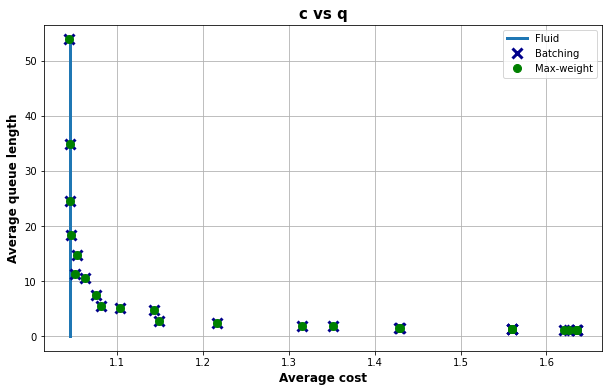

In [24]:
fluid_sol = run_extremes(N,W,pmf_cust,pmf_serv)

plt.figure( figsize=(10,6) ) 

# C = 0 Case

# C = Inf/Fluid Case
ylim = max( max( average_queue_B ), max( average_queue_M ) )
plt.plot([fluid_sol['Cost'],fluid_sol['Cost']],[0,ylim],linewidth = 3)
# Batching data
plt.plot(average_cost_B,average_queue_B,'x',markersize = 10, markeredgewidth=3, markeredgecolor="darkblue")
# Max Weight data
plt.plot(average_cost_M, average_queue_M,'go',markersize = 8)
# plt.plot([Ex],[1],'r*',markersize = 12, markeredgewidth=3)
plt.ylabel("Average queue length", weight='bold',fontsize=12)
plt.xlabel("Average cost", weight='bold',fontsize=12)
plt.title("c vs q", weight='bold',fontsize=15)
plt.legend(['Fluid', 'Batching', 'Max-weight', 'c = 0 sol'])
# plt.legend([ 'Batching', 'Max-weight', 'c = 0 sol'])
plt.grid(True)

plt.show()

In [25]:
fluid_sol

{'X': array([[1.02485060e-14, 4.86111113e-02, 2.03717650e-11, 4.86111108e-02,
         1.38888889e-02, 6.98281105e-12, 2.03717650e-11, 6.98281105e-12,
         5.97704366e-12],
        [4.86111114e-02, 1.89716850e-14, 4.86111107e-02, 1.48855041e-11,
         1.38888889e-02, 1.48855041e-11, 6.98281105e-12, 3.99659493e-12,
         6.98281105e-12],
        [2.03717650e-11, 4.86111109e-02, 1.02485060e-14, 6.98281105e-12,
         1.38888889e-02, 4.86111112e-02, 5.97704366e-12, 6.98281105e-12,
         2.03717650e-11],
        [4.86111107e-02, 1.48855041e-11, 6.98281105e-12, 1.89716851e-14,
         1.38888889e-02, 3.99659493e-12, 4.86111115e-02, 1.48855041e-11,
         6.98281105e-12],
        [1.38888889e-02, 1.38888888e-02, 1.38888889e-02, 1.38888889e-02,
         3.00729978e-14, 1.38888889e-02, 1.38888889e-02, 1.38888889e-02,
         1.38888889e-02],
        [6.98281105e-12, 1.48855041e-11, 4.86111114e-02, 3.99659493e-12,
         1.38888889e-02, 1.89716850e-14, 6.98281105e-12, 1.488